In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['errorbar.capsize'] = 12
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

enss=['b']
ens2full={'a24':'cA211.53.24','a':'cA2.09.48','b':'B64','c':'C80','d':'D96'}
ens2label={'a24':'A24','a':'A48','b':'B64','c':'C80','d':'D96'}
ens2a={'a24':0.0908,'a':0.0938,'b':0.07957,'c':0.06821,'d':0.05692} # fm
ens2N={'a24':24,'a':48,'b':64,'c':80,'d':96}
ens2N_T={'a24':24*2,'a':48*2,'b':64*2,'c':80*2,'d':96*2}

# ens2mN={'a':931}
# ens2mpiC={'a':131}
# ens2mpi0={'a':111}

ens2amu={'a24':0.0053,'a':0.0009,'b':0.00072}
ens2ZP={'a24':(0.4670,0.0046),'a':(0.500,0.030)}

hbarc = 1/197.3
ens2aInv={ens:1/(ens2a[ens]*hbarc) for ens in enss} # MeV

ens='b'

In [2]:
Tpack=32; d_jk=1
path='/capstor/store/cscs/userlab/s1174/lyan/code/projectData2/01_Nsgm/cB211.072.64_base/data_merge/Nsgm_4src_16,18,20.h5'
data=yu.load(path,d=d_jk)
Ncfg,Njk=data['cfgs'][1:]
print(f'Ncfg={Ncfg},Njk={Njk}')

cfg2old=lambda cfg: cfg[1:]+'_r'+{'a':'0','b':'1','c':'2','d':'3'}[cfg[0]]
cfg2new=lambda cfg: {'0':'a','1':'b','2':'c','3':'d'}[cfg[-1]] + cfg[:4]

tfs=[8,10,12,14,16,18,20]
path='/capstor/store/cscs/userlab/s1174/lyan/code/projectData2/01_Nsgm/cB211.072.64_base/data_from_others/thrp-conn.h5'
with h5py.File(path) as f:
    # cfgs_NJN=[cfg2new(cfg) for cfg in f['gS/up/dt10'].keys()]
    cfgs_old=[cfg2old(cfg) for cfg in data['cfgs'][0]]

    c3ptDic_NJN={tf:np.real(yu.jackknife([f[f'gS/up/dt{tf}/{cfg}'][:] + f[f'gS/dn/dt{tf}/{cfg}'][:] for cfg in cfgs_old],d=d_jk)) for tf in tfs}
    c2ptCorrDic_NJN={tf:np.real(yu.jackknife([f[f'dt{tf}_twop/{cfg}'][()] for cfg in cfgs_old],d=d_jk)) for tf in tfs}

loading: /capstor/store/cscs/userlab/s1174/lyan/code/projectData2/01_Nsgm/cB211.072.64_base/data_merge/Nsgm_4src_16,18,20.h5
482/482: diags/Z3pt/srcs/Z3pt.h5_NJNpi-Nsrc=4*1                               
Ncfg=732,Njk=732


In [3]:
flags={
    'cc2pt':True, # average quantities related by complex conjugation for 2pt
    'cc3pt':True, # same for 3pt (Removal of vacuum expectation value requires 'cc2pt'=='cc3pt')
    'll2pt':True, # average irrep rows 'l1' and conjugated 'l2' (Parity breaking effect of tmQCD has been taken care of)
    'll3pt':True, # same for 3pt (This flag has no effect if 'll2pt'=True and spin-projection is done)
    'r2pt': True, # making 2ptMat real for the rest frame # 'll2pt' has to be real for this flag
    'remove_pi0VEV':True, 
    'remove_jVEV':True,
}

def op_remove_pi0(op):
    t=op.split(';')
    if t[-1] in ['p','n','n,pi+']:
        return False
    if t[3] not in ['N0pi0,a','N1pi0,a','N0sgm0,a','N1sgm0,a']:
        return False
    if t[3] in ['N0sgm0,a','N1sgm0,a']:
        t[3]='a'
        t[-1]={'p,sgm':'p'}[t[-1]]
        return ';'.join(t)
    if t[2] == 'G1u':
        t[2]='G1g'
        assert(t[3]=='N0pi0,a'); t[3]='a'
        assert(t[-1]=='p,pi0'); t[-1]='p'
        return ';'.join(t)

def get2pt_diag(opa,opb,diag):
    opab=f'{opa}_{opb}'
    if opab not in data['2pt'].keys() or diag not in data['2pt'][opab].keys():
        return 0
    res=data['2pt'][opab][diag].copy()
    if not flags['remove_pi0VEV']:
        return res
    if diag == 'pi0f-pi0i':
        if opa==opb and opa=='t;0,0,0;pi0':
            res -= (data['VEV']['pi0f']**2)[:,None]
        return res
    
    if 'pi0f' in diag.split('-'):
        t_opa=op_remove_pi0(opa)
        if t_opa != False:
            t=diag.split('-'); t.remove('pi0f'); t_diag='-'.join(t)
            res -= data['2pt'][f'{t_opa}_{opb}'][t_diag] * data['VEV']['pi0f'][opa.split(';')[-1].split(',')[-1]][:,None]
    if 'pi0i' in diag.split('-'):
        t_opb=op_remove_pi0(opb)
        if t_opb != False:
            t=diag.split('-'); t.remove('pi0i'); t_diag='-'.join(t)
            res -= data['2pt'][f'{opa}_{t_opb}'][t_diag] * np.conj(data['VEV']['pi0f'][opb.split(';')[-1].split(',')[-1]][:,None])
    if 'pi0f' in diag.split('-') and 'pi0i' in diag.split('-'):
        t_opa=op_remove_pi0(opa); t_opb=op_remove_pi0(opb)
        if t_opa != False and t_opb != False:
            t=diag.split('-'); t.remove('pi0f'); t.remove('pi0i'); t_diag='-'.join(t)
            res += data['2pt'][f'{t_opa}_{t_opb}'][t_diag] * data['VEV']['pi0f'][opa.split(';')[-1].split(',')[-1]][:,None] * np.conj(data['VEV']['pi0f'][opb.split(';')[-1].split(',')[-1]][:,None])
    return res

def get2pt(opa,opb,diags=yu.diags_all):
    res=np.zeros([Njk,Tpack],dtype=complex)
    opab=f'{opa}_{opb}'; opba=f'{opb}_{opa}'
    if opab in data['2pt']:
        res+=np.sum([get2pt_diag(opa,opb,diag) for diag in data['2pt'][opab].keys() if diag in diags],axis=0)
    if opba in data['2pt']:
        diags_cc={'T', 'T-pi0f'}; 
        res+=np.conj(np.sum([get2pt_diag(opa,opb,diag) for diag in data['2pt'][opba].keys() if diag in diags_cc and diag in diags],axis=0))
    return res

def get2ptMat(ops,diags=yu.diags_all):
    if flags['ll2pt']:
        flags['ll2pt']=False
        ops_flip=[yu.op_flipl(op) for op in ops]
        t=(get2ptMat(ops,diags=diags)+np.conj(get2ptMat(ops_flip,diags=diags)))/2
        flags['ll2pt']=True
        if ops[0].split(';')[1]=='0,0,0' and flags['r2pt']:
            t=np.real(t)
        return t
    t=np.transpose([[get2pt(opa,opb,diags) for opb in ops] for opa in ops],[2,3,0,1])
    if flags['cc2pt']:
        t=(t+np.conj(np.transpose(t,[0,1,3,2])))/2
    return t

tfs=[8,10,12,14,16,18,20]

def get3pt_diag(opa,opb,insert,diag):
    if opa in ['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;a;l2;p'] and opb in ['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;a;l2;p'] and insert.startswith('id_j+_') and diag=='NJN':
        gm,j,tf=insert.split('_')
        res=c3ptDic_NJN[int(tf)]
        return res
    
    opab=f'{opa}_{opb}'
    if opab not in data['3pt'].keys() or diag not in data['3pt'][opab][insert].keys():
        return 0
    res=data['3pt'][opab][insert][diag].copy()
    if flags['remove_pi0VEV']:
        if 'pi0f' in diag.split('-'):
            t_opa=op_remove_pi0(opa)
            if t_opa != False:
                t=diag.split('-'); t.remove('pi0f'); t_diag='-'.join(t)
                res -= data['3pt'][f'{t_opa}_{opb}'][insert][t_diag] * data['VEV']['pi0f'][opa.split(';')[-1].split(',')[-1]][:,None]
        if 'pi0i' in diag.split('-'):
            t_opb=op_remove_pi0(opb)
            if t_opb != False:
                t=diag.split('-'); t.remove('pi0i'); t_diag='-'.join(t)
                res -= data['3pt'][f'{opa}_{t_opb}'][insert][t_diag] * np.conj(data['VEV']['pi0f'][opb.split(';')[-1].split(',')[-1]][:,None])
        if 'pi0f' in diag.split('-') and 'pi0i' in diag.split('-'):
            t_opa=op_remove_pi0(opa); t_opb=op_remove_pi0(opb)
            if t_opa != False and t_opb != False:
                t=diag.split('-'); t.remove('pi0f'); t.remove('pi0i'); t_diag='-'.join(t)
                res += data['3pt'][f'{t_opa}_{t_opb}'][insert][t_diag] * data['VEV']['pi0f'][opa.split(';')[-1].split(',')[-1]][:,None] * np.conj(data['VEV']['pi0f'][opb.split(';')[-1].split(',')[-1]][:,None])
    if flags['remove_jVEV']:
        gm,j,tf=insert.split('_')
        t_insert='_'.join([gm,j])
        if 'j' in diag.split('-') and t_insert in ['id_j+','id_js','id_jc','g5_j-']:
            t=diag.split('-'); t.remove('j'); t_diag='-'.join(t)
            res -= (get2pt_diag(opa,opb,t_diag)[:,int(tf)] * data['VEV']['j'][t_insert])[:,None]
    return res

def get3pt(opa,opb,insert,diags=yu.diags_all):
    res=np.zeros([Njk,int(insert.split('_')[-1])+1],dtype=complex)
    opab=f'{opa}_{opb}'; opba=f'{opb}_{opa}'
    if opab in data['3pt']:
        res+=np.sum([get3pt_diag(opa,opb,insert,diag) for diag in data['3pt'][opab][insert].keys() if diag in diags],axis=0)
    if opba in data['3pt']:
        t=data['3pt'][opb+'_'+opa][insert]; 
        diags_cc={'B3pt','W3pt','Z3pt','T-j', 'T-pi0f-j','T-jPf','B3pt-pi0f','W3pt-pi0f','Z3pt-pi0f'}; 
        if opab not in data['3pt'] or 'NJN-pi0f' not in data['3pt'][opab][insert]:
            diags_cc.add('NJN-pi0i')
        t_add=np.zeros([Njk,int(insert.split('_')[-1])+1],dtype=complex)+np.sum([get3pt_diag(opb,opa,insert,diag) for diag in t.keys() if diag in diags_cc and diag in diags],axis=0)
        res+=np.conj(t_add[:,::-1])*(yu.gtCj[insert.split('_')[0]])
    return res

def get3ptMat(opas,opbs,insert,diags=yu.diags_all):
    if flags['ll3pt']:
        flags['ll3pt']=False
        opas_flip=[yu.op_flipl(op) for op in opas]; opbs_flip=[yu.op_flipl(op) for op in opbs]
        sgns=np.array([[yu.op_getl_sgn(opa)*yu.op_getl_sgn(opb) for opb in opbs] for opa in opas])
        sgns*=yu.fourCPTstar[insert.split('_')[0]]
        t=(get3ptMat(opas,opbs,insert,diags=diags)+np.conj(get3ptMat(opas_flip,opbs_flip,insert,diags=diags))*sgns[None,None,:,:])/2
        flags['ll3pt']=True
        return t
    t=np.transpose([[get3pt(opa,opb,insert,diags) for opb in opbs] for opa in opas],[2,3,0,1])
    if flags['cc3pt']:
        flags['cc3pt']=False
        tt=get3ptMat(opbs,opas,insert,diags)[:,::-1]*(yu.gtCj[insert.split('_')[0]])
        flags['cc3pt']=True
        t=(t+np.conj(np.transpose(tt,[0,1,3,2])))/2
    return t

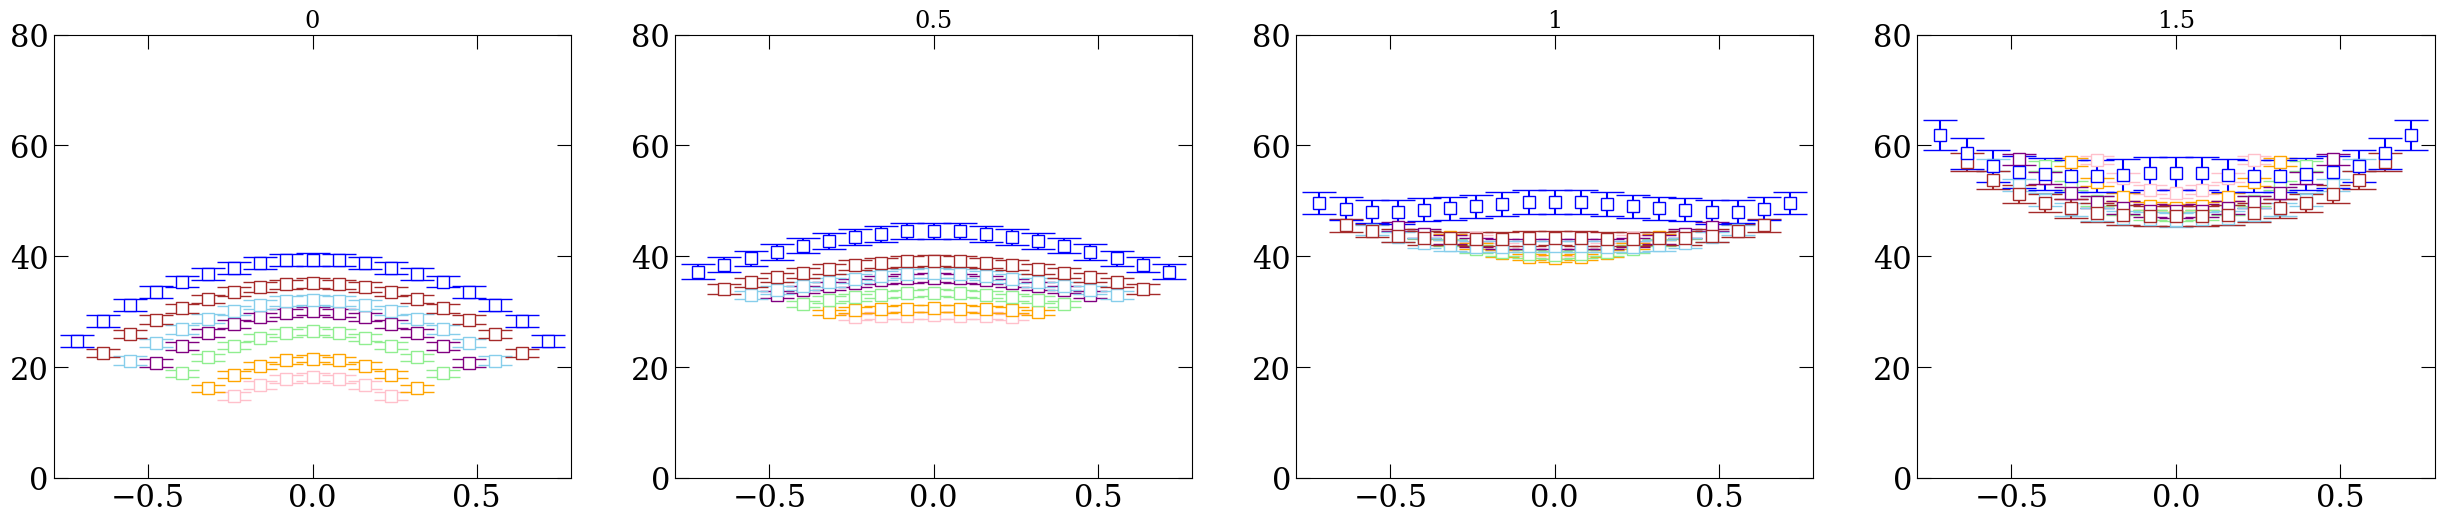

In [45]:
settings={
    'ylim':[0,80],
}

colorDic={8:'pink',10:'orange',12:'lightgreen',14:'purple',16:'skyblue',18:'brown',20:'blue'}
fmtDic={4:'v',5:'d',6:'o',7:'s',8:'<',9:'>',10:'^'}

ops=['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;N0sgm0,a;l1;p,sgm']
j='j+'; tfs=[8,10,12,14,16,18,20]

c2ptM=get2ptMat(ops)
# for tf in c2ptCorrDic_NJN.keys():
#     c2ptM[:,tf,0,0]=c2ptCorrDic_NJN[tf]
c3ptM_dic={tf:get3ptMat(ops,ops,f'id_{j}_{tf}',diags=yu.diags_all) for tf in tfs}

GEVP_t0,GEVP_t=7,14
evals,evecs=yu.GEVP(np.mean(c2ptM,axis=0),GEVP_t0)
Revec=evecs[GEVP_t,0,1]/evecs[GEVP_t,0,0]

lbds=[0,0.5,1,1.5]
# lbds=[0]
fig, axs = yu.getFigAxs(1,len(lbds))
yu.addColHeader(axs,lbds)

for i,lbd in enumerate(lbds):
    # print(lbd)
    x=Revec*lbd
    c2pt=np.real(c2ptM[:,:,0,0] + x*c2ptM[:,:,0,1] + x*c2ptM[:,:,1,0] + x**2*c2ptM[:,:,1,1] *0)
    c3ptDic={tf:np.real(c3ptM_dic[tf][:,:,0,0]+ x*c3ptM_dic[tf][:,:,0,1] + x*c3ptM_dic[tf][:,:,1,0]) for tf in tfs}
    c2ptCorrDic={tf:np.real(c2ptCorrDic_NJN[tf] + x*c2ptM[:,tf,0,1] + x*c2ptM[:,tf,1,0]) for tf in tfs}

    ratioCorr={tf:c3ptDic[tf][:,:]/c2ptCorrDic[tf][:,None] for tf in tfs}


    # fig, axs = yu.getFigAxs(1,1)
    # fig.suptitle(f'lambda={lbd}')

    ax=axs[0,i]
    xunit=ens2a[ens]; yunit=[1,0.4638,ens2amu[ens]*ens2aInv[ens],][2]
    ax.set_ylim(settings['ylim'])
    for tf in tfs[:]:
        t_cut=1
        
        ratio=ratioCorr[tf]
        mean,err=yu.jackme(ratio)
        
        if tf%2==0:
            plt_x=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        else:
            plt_x=(np.arange(t_cut - tf//2,tf//2 - (t_cut-1)+1)-0.5)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colorDic[tf] if tf in colorDic else None,mfc='white')  
        
        # if tf%2==0:
        #     plt_x=np.arange(t_cut, tf - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        # else:
        #     plt_x=(np.arange(t_cut, tf - (t_cut-1)+1)-0.5)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        # ax.errorbar(plt_x,plt_y,plt_yerr,color=colorDic[tf] if tf in colorDic else None,mfc='white')  
        
        
        # ratio=ratioCorr[tf][:,:tf//2+1] #/ratioCorr[tf][:,tf//2:tf//2+1]
        # ratio=ratio[:,t_cut:]
        # mean,err,cov=yu.jackmec(ratio)
        
        # t=np.sqrt(np.diag(cov))
        # correlation=cov/np.outer(t,t)
        # print(tf)
        # for row in correlation:
        #     for ele in row:
        #         print('{:.2f}'.format(ele),end='  ')
        #     print()
            
        # t=cov
        # evals,evecs=np.linalg.eig(t)
        # inds=np.argsort(-evals)
        # evals=evals[inds]; evecs=evecs[:,inds]
        # for i in range(len(t)):
        #     print(i,np.sqrt(evals[i]))
        #     print(evecs[:,i])
        
        # break
    
    # print()


0
20
1.00  0.99  0.95  0.89  0.82  0.74  0.64  0.53  0.39  
0.99  1.00  0.98  0.94  0.87  0.79  0.69  0.57  0.42  
0.95  0.98  1.00  0.98  0.93  0.85  0.75  0.63  0.46  
0.89  0.94  0.98  1.00  0.98  0.91  0.81  0.69  0.51  
0.82  0.87  0.93  0.98  1.00  0.97  0.89  0.77  0.58  
0.74  0.79  0.85  0.91  0.97  1.00  0.96  0.86  0.66  
0.64  0.69  0.75  0.81  0.89  0.96  1.00  0.95  0.76  
0.53  0.57  0.63  0.69  0.77  0.86  0.95  1.00  0.89  
0.39  0.42  0.46  0.51  0.58  0.66  0.76  0.89  1.00  
0 0.8788884318736973
[0.5003836  0.47654619 0.43573333 0.38096494 0.31419009 0.23900323
 0.15683413 0.0810094  0.0229072 ]
1 0.23315811928879818
[ 0.49150882  0.29702682  0.03994298 -0.20912151 -0.39796645 -0.47029057
 -0.41368643 -0.25870533 -0.08515559]
2 0.10323226347125809
[ 0.45934704  0.0220881  -0.36387865 -0.45223426 -0.19091663  0.19099595
  0.43743914  0.40018271  0.16480624]
3 0.053109513371725564
[-0.36006492  0.23506345  0.43662003  0.03965219 -0.43053976 -0.31084618
  0.1717019   0

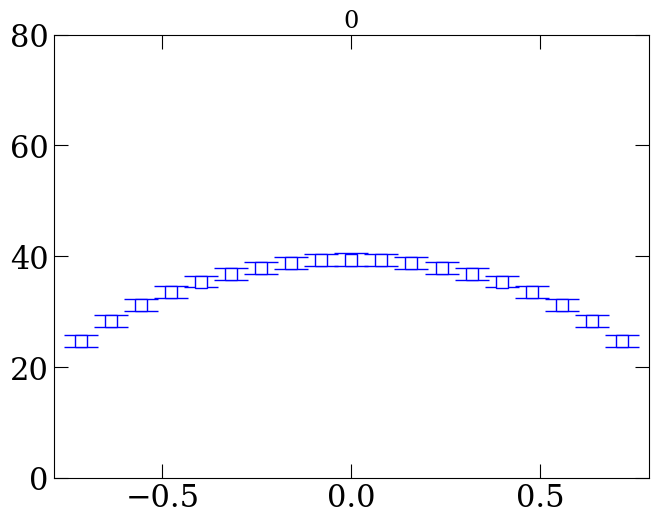

In [49]:
settings={
    'ylim':[0,80],
}

colorDic={8:'pink',10:'orange',12:'lightgreen',14:'purple',16:'skyblue',18:'brown',20:'blue'}
fmtDic={4:'v',5:'d',6:'o',7:'s',8:'<',9:'>',10:'^'}

ops=['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;N0sgm0,a;l1;p,sgm']
j='j+'; tfs=[8,10,12,14,16,18,20]

c2ptM=get2ptMat(ops)
# for tf in c2ptCorrDic_NJN.keys():
#     c2ptM[:,tf,0,0]=c2ptCorrDic_NJN[tf]
c3ptM_dic={tf:get3ptMat(ops,ops,f'id_{j}_{tf}',diags=yu.diags_all) for tf in tfs}

GEVP_t0,GEVP_t=7,14
evals,evecs=yu.GEVP(np.mean(c2ptM,axis=0),GEVP_t0)
Revec=evecs[GEVP_t,0,1]/evecs[GEVP_t,0,0]

lbds=[0,0.5,1,1.5]
lbds=[0]
fig, axs = yu.getFigAxs(1,len(lbds))
yu.addColHeader(axs,lbds)

for i,lbd in enumerate(lbds):
    print(lbd)
    x=Revec*lbd
    c2pt=np.real(c2ptM[:,:,0,0] + x*c2ptM[:,:,0,1] + x*c2ptM[:,:,1,0] + x**2*c2ptM[:,:,1,1] *0)
    c3ptDic={tf:np.real(c3ptM_dic[tf][:,:,0,0]+ x*c3ptM_dic[tf][:,:,0,1] + x*c3ptM_dic[tf][:,:,1,0]) for tf in tfs}
    c2ptCorrDic={tf:np.real(c2ptCorrDic_NJN[tf] + x*c2ptM[:,tf,0,1] + x*c2ptM[:,tf,1,0]) for tf in tfs}

    ratioCorr={tf:c3ptDic[tf][:,:]/c2ptCorrDic[tf][:,None] for tf in tfs}


    # fig, axs = yu.getFigAxs(1,1)
    # fig.suptitle(f'lambda={lbd}')

    ax=axs[0,i]
    xunit=ens2a[ens]; yunit=[1,0.4638,ens2amu[ens]*ens2aInv[ens],][2]
    ax.set_ylim(settings['ylim'])
    for tf in tfs[-1:]:
        t_cut=1
        
        ratio=ratioCorr[tf]
        mean,err=yu.jackme(ratio)
        
        if tf%2==0:
            plt_x=np.arange(t_cut - tf//2,tf//2 - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        else:
            plt_x=(np.arange(t_cut - tf//2,tf//2 - (t_cut-1)+1)-0.5)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colorDic[tf] if tf in colorDic else None,mfc='white')  
        
        # if tf%2==0:
        #     plt_x=np.arange(t_cut, tf - (t_cut-1))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        # else:
        #     plt_x=(np.arange(t_cut, tf - (t_cut-1)+1)-0.5)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
        # ax.errorbar(plt_x,plt_y,plt_yerr,color=colorDic[tf] if tf in colorDic else None,mfc='white')  
        
        
        ratio=ratioCorr[tf][:,:tf//2] - ratioCorr[tf][:,tf//2:tf//2+1]
        ratio=ratio[:,t_cut:]
        mean,err,cov=yu.jackmec(ratio)
        
        t=np.sqrt(np.diag(cov))
        correlation=cov/np.outer(t,t)
        print(tf)
        for row in correlation:
            for ele in row:
                print('{:.2f}'.format(ele),end='  ')
            print()
            
        t=cov
        evals,evecs=np.linalg.eig(t)
        inds=np.argsort(-evals)
        evals=evals[inds]; evecs=evecs[:,inds]
        for i in range(len(t)):
            print(i,np.sqrt(evals[i]))
            print(evecs[:,i])
        
        break
    
    print()
